<a href="https://colab.research.google.com/github/yuki0703-sudo/Research/blob/main/MotionPrediction_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,LSTM
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils  import model_to_dot
from keras.utils import plot_model

#load csv file
import pandas as pd

#Scaled module
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#prepare for training
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

In [ ]:
# connected Google Drive
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


#Process data and calculate velocity

##calculate velocity and split data

In [ ]:
def pos2vel(src):
  import pandas as pd
  file = pd.read_csv(filepath_or_buffer=src)
  data = file.values
  data = data.tolist()
  value = []
  len_data = 10 # len(data[i])
  for i in range(1,len(data)):
    temp = data[i]
    for j in range(len(data[i])):
      #print((i,j))
      #print((i,j))
      vel = data[i][j]-data[i-1][j]
      temp.append(vel)
    value.append(temp)
  value = np.array(value)
  print('data shape : ', value.shape)
  return value

In [ ]:
##only position data to position and velocity data
value1_train = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/1.csv")
value2_train = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/2.csv")[:1300,:]
value_predict = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/2.csv")[1300:,:]
value3_train = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/3.csv")[:800,:]
value_test = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/3.csv")[800:,:]

# ensure all data is float
value1_train = value1_train.astype('float32')
value2_train = value2_train.astype('float32')
value3_train = value3_train.astype('float32')
value_test = value_test.astype('float32')

data shape :  (3572, 20)
data shape :  (1699, 20)
data shape :  (1699, 20)
data shape :  (1406, 20)
data shape :  (1406, 20)


##Noise Cancelling

<Figure size 432x288 with 0 Axes>

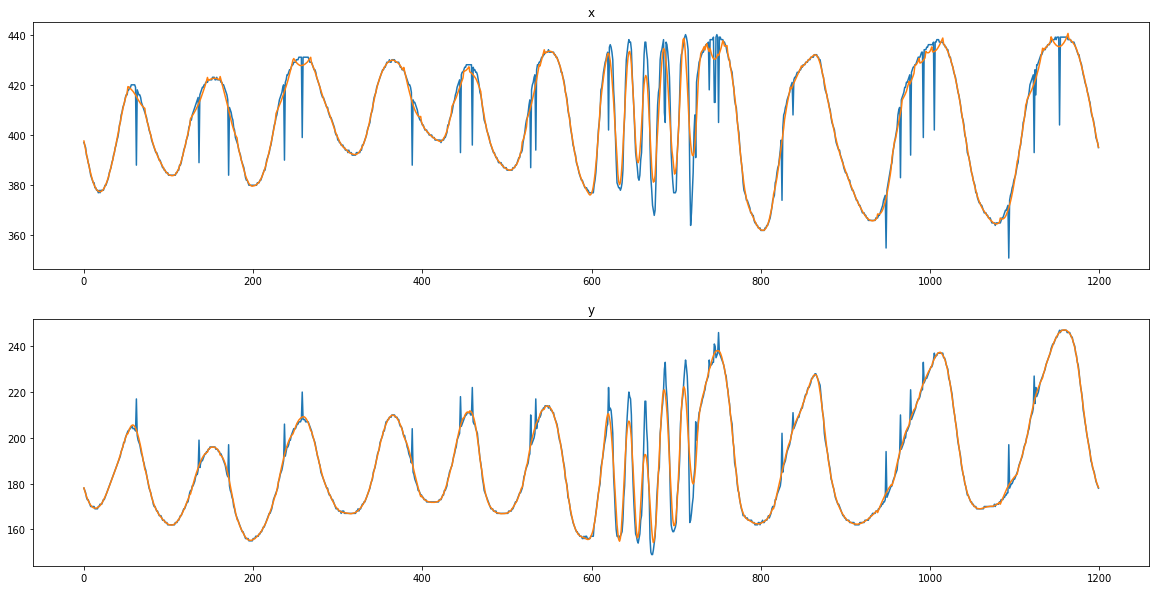

In [ ]:
# noise cancel
import scipy as sp
window = 21 # window length must be odd
deg = 3
def noise_removal(data,window,deg):
	smooth = np.zeros((len(data),len(data[1])))
	for i in range(len(value1_train[1])):
		smooth[:,i] = sp.signal.savgol_filter(data[:,i],window,deg) 
	return smooth
smooth1_train = noise_removal(value1_train,window,deg)
smooth2_train = noise_removal(value2_train, 9, deg)
smooth3_train = noise_removal(value3_train, 11, deg)
smooth_test = noise_removal(value_test, 5, deg)
smooth_predict = noise_removal(value_predict, 5, deg)

#インストールしたデータのプロット
#specify columns to plot
groups=[0,1]
title=["x","y"]
i=1
plt.figure()
plt.subplots(figsize = (20,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(value1_train[:1200, group])
	plt.plot(smooth1_train[:1200, group])
	plt.title(title[group])
	i += 1
plt.show()

##Normalization

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled1_train = scaler.fit_transform(smooth1_train)
scaled2_train = scaler.fit_transform(smooth2_train)
scaled3_train = scaler.fit_transform(smooth3_train)
scaled_test = scaler.fit_transform(smooth_test)
scaled_predict = scaler.fit_transform(smooth_predict)

##Change the format of data

In [ ]:
##########
lookback = 30

def transform_NN(before_data,lookback):
  before_data = before_data.tolist()
  train1_X = []
  train1_y = []
  for j in range(len(before_data)-lookback):
    train1_y.append(before_data[lookback+j-1])
    temp = before_data[j:j+lookback]
    temp_list =[]
    for i in range(lookback):
      #for k in range(len(temp[i])):
      temp_list.append(temp[i])
    train1_X.append(temp_list)
  train1_X = np.array(train1_X)
  train1_y = np.array(train1_y)
  print("shape : (X,y):", (train1_X.shape,train1_y.shape))
  return train1_X,train1_y

In [ ]:
train1_X, train1_y = transform_NN(scaled1_train,lookback)
train2_X, train2_y = transform_NN(scaled2_train,lookback)
train3_X, train3_y = transform_NN(scaled3_train,lookback)
test_X, test_y = transform_NN(scaled_test,lookback)
predict_X, predict_y = transform_NN(scaled_predict,lookback)

shape : (X,y): ((3542, 30, 20), (3542, 20))
shape : (X,y): ((1270, 30, 20), (1270, 20))
shape : (X,y): ((770, 30, 20), (770, 20))
shape : (X,y): ((576, 30, 20), (576, 20))
shape : (X,y): ((369, 30, 20), (369, 20))


##Combine all the data

In [ ]:
def combine_train(data1,data2,data3):
  data1 = data1.tolist()
  data2 = data2.tolist()
  data3 = data3.tolist()
  train = []
  for i in range(len(data1)): #(1200,100,20),1200
    temp= []
    for j in range(len(data1[i])):#100
      temp_2 =[]
      for k in range(len(data1[i][j])):#20
        temp_2.append(data1[i][j][k])
      temp.append(temp_2)
    train.append(temp)
  for i in range(len(data2)): #(1200,100,20),1200
    temp= []
    for j in range(len(data2[i])):#100
      temp_2 =[]
      for k in range(len(data2[i][j])):#20
        temp_2.append(data2[i][j][k])
      temp.append(temp_2)
    train.append(temp)
  for i in range(len(data3)): #(1200,100,20),1200
    temp= []
    for j in range(len(data3[i])):#100
      temp_2 =[]
      for k in range(len(data3[i][j])):#20
        temp_2.append(data3[i][j][k])
      temp.append(temp_2)
    train.append(temp)
  train = np.asarray(train)
  print('train data shape', train.shape)
  return train

def combine_label(data1,data2,data3):
  data1 = data1.tolist()
  data2 = data2.tolist()
  data3 = data3.tolist()
  train_label = []
  for i in range(len(data1)): #(1200,100,20),1200
    temp= []
    for j in range(len(data1[i])):#100
      temp.append(data1[i][j])
    train_label.append(temp)
  for i in range(len(data2)): #(1200,100,20),1200
    temp= []
    for j in range(len(data2[i])):#100
      temp.append(data2[i][j])
    train_label.append(temp)
  for i in range(len(data3)): #(1200,100,20),1200
    temp= []
    for j in range(len(data3[i])):#100
      temp.append(data3[i][j])
    train_label.append(temp)
  train_label = np.asarray(train_label)
  print('train_label shape:',train_label.shape)
  return train_label

In [ ]:
train = combine_train(train1_X,train2_X,train3_X)
train_label = combine_label(train1_y,train2_y,train3_y)

train data shape (5582, 30, 20)
train_label shape: (5582, 20)


# Making TCN model

In [ ]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies  # without the dependencies if you already have TF/Numpy.!!

In [ ]:
#import module for making prediction model : 
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [ ]:
# define parameters : 
look_back = 30
batch_size = 32
time_step = look_back
input_dim = 20

# define TCN model
#TCN(
 #   nb_filters=64,
 #   kernel_size=3,
 #   nb_stacks=1,
 #   dilations=(1, 2, 4, 8, 16, 32),
 #   padding='causal',
 #   use_skip_connections=True,
 #   dropout_rate=0.0,
 #   return_sequences=False,
 #   activation='relu',
 #   kernel_initializer='he_normal',
 #   use_batch_norm=False,
 #   use_layer_norm=False,
 #   use_weight_norm=False,
 #   **kwargs
#)

tcn_layer = TCN(input_shape = (time_step, input_dim),
                nb_filters = 16, 
                kernel_size = 3,
                nb_stacks = 1, #when using 100,000~ time steps
                dilations = (1,2,4,8,16),
                padding = 'causal',
                use_skip_connections = True,
                return_sequences = False,
                dropout_rate = 0.0,
                activation = "relu",
                kernel_initializer = "he_normal",
                use_batch_norm = False,
                use_layer_norm = False,
                use_weight_norm = False)
                #**kwargs,    
                #)

print("Receptive field size : ", tcn_layer.receptive_field)

model = Sequential([
    tcn_layer,
    Dense(20, activation = "softmax")
])

opt = keras.optimizers.Adam(learning_rate = 0.001,decay = 0.0001)
model.compile(optimizer = opt,
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = ["mean_squared_error"]
              )
              
tcn_full_summary(model, expand_residual_blocks = False)

Receptive field size :  253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.


#Training

In [ ]:

#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
save_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/predicition/NN/handmotion/TCN/1108_.{epoch:02d}-{val_loss:.2f}.hdf5'
Modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath = save_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train,train_label,epochs = 200, validation_split = 0.2,callbacks = [Modelcheckpoint])

#plot vonverging process : 
plt.plot(history.history["loss"],label = "Loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.show()

Epoch 1/200
137/140 [============================>.] - ETA: 0s - loss: 0.1395 - mean_squared_error: 0.1395
Epoch 1: val_loss improved from inf to 0.17206, saving model to /content/gdrive/My Drive/YAMAKAWA_LAB/predicition/NN/handmotion/TCN/1108_.01-0.17.hdf5
140/140 [==============================] - 8s 39ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.1721 - val_mean_squared_error: 0.1721
Epoch 2/200
138/140 [============================>.] - ETA: 0s - loss: 0.1298 - mean_squared_error: 0.1298
Epoch 2: val_loss improved from 0.17206 to 0.16421, saving model to /content/gdrive/My Drive/YAMAKAWA_LAB/predicition/NN/handmotion/TCN/1108_.02-0.16.hdf5
140/140 [==============================] - 3s 22ms/step - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1642 - val_mean_squared_error: 0.1642
Epoch 3/200
139/140 [============================>.] - ETA: 0s - loss: 0.1287 - mean_squared_error: 0.1287
Epoch 3: val_loss did not improve from 0.16421
140/140 [=============

#Hyperparameter Tuning

In [ ]:
## Hyperparameter tuning -> Keras Tuner training https://keras.io/guides/keras_tuner/getting_started/
!pip install -U keras-tuner

In [ ]:
from kerastuner.tuners import RandomSearch
import keras
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
#hyperparameter tuning:
time_step=30
input_dim = 20
def build_model(hp):
  model = keras.Sequential()
  tcn_layer = TCN(input_shape = (time_step, input_dim),
                nb_filters = hp.Choice(f"{i} dilation", [16,16]), 
                kernel_size = 3,
                nb_stacks = 1, #when using 100,000~ time steps
                dilations = [1,2,4,8],
                padding = 'causal',
                use_skip_connections = True,
                return_sequences = False,
                dropout_rate = 0.0,
                activation = "relu",
                kernel_initializer = "he_normal",
                use_batch_norm = False,
                use_layer_norm = False,
                use_weight_norm = False
                #**kwargs,    
                )

  print("Receptive field size : ", tcn_layer.receptive_field)

  model = Sequential([
    tcn_layer,
    Dense(20, activation = "softmax")
])
  opt = keras.optimizers.Adam(learning_rate=0.001,decay=0.0001)
  model.compile(optimizer = opt,
                loss =tf.keras.losses.MeanSquaredError(),
                metrics =["mean_squared_error"])
  
  return model

import os

save_dir = "/content/gdrive/My Drive/YAMAKAWA_LAB/prediction/NN/fingermotion/1108/TCN"
#src_img_dirがなかったら、srcフォルダを作成する
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

tuner = RandomSearch(
    build_model,
    objective = "mean_squared_error",
    max_trials = 10,
    directory = save_dir,
    project_name = "1108" #change every time
)

tuner.search(train, train_label,validation_split = 0.2, epochs=300, batch_size =64)

Trial 10 Complete [00h 09m 24s]
mean_squared_error: 0.12357653677463531

Best mean_squared_error So Far: 0.12291789054870605
Total elapsed time: 01h 21m 36s


##Get Result

In [ ]:
model = tuner.get_best_models()[0]

best_model.summary()
#configure the result of the tuning
tuner.results_summary()

Receptive field size :  61
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 16)                6800      
                                                                 
 dense (Dense)               (None, 20)                340       
                                                                 
Total params: 7,140
Trainable params: 7,140
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in /content/gdrive/My Drive/YAMAKAWA_LAB/prediction/NN/fingermotion/1108/TCN/1108
Showing 10 best trials
Trial summary
Hyperparameters:
1 dilation: 16
3 dilation: 16
Score: 0.12291789054870605
Trial summary
Hyperparameters:
1 dilation: 32
3 dilation: 32
Score: 0.12311254441738129
Trial summary
Hyperparameters:
1 dilation: 8
3 dilation: 16
Score: 0.12357653677463531
Trial summary
Hyperparameters

#Evaluation 

In [ ]:
def getNewestModel(model, dirname):
    from glob import glob
    import os
    
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model

model = getNewestModel(model, save_dir)

In [ ]:
#evaluate the learning process
import math
from sklearn.metrics import mean_squared_error

def mean_squared_error(data1, data2):
  s = 0
  for i in range(len(data1)):
    s += (data1[i][0]-data2[i][0])**2+(data1[i][0]-data2[i][1])**2
  s = s/len(data1)
  return s

# train_evaluation and test evaluation
scaled_y_hat_test = model.predict(test_X)
scaled_y_hat_train = model.predict(train)

#convert scaled data into original data
yhat_test =  scaler.inverse_transform(scaled_y_hat_test)
yhat_train = scaler.inverse_transform(scaled_y_hat_train)

train_evaluation = scaler.inverse_transform(train_label)
test_evaluation = scaler.inverse_transform(test_y)
#evaluation data : convert scaled data into original data 
#inv_y_test_eva = scaler.inverse_transform(test_Y)
#inv_y_train_eva = scaler.inverse_transfrom(train_Y)

print("prediction_test: ",yhat_test[:5,:])
print("evaluation_data: ", test_evaluation[:5,:])

#calculate RMSE:
rmse_train = mean_squared_error(yhat_train, train_evaluation)
rmse_test = mean_squared_error(yhat_test, test_evaluation)

#show results:
print("RMSE in train : " , rmse_train)
print("RMSE in test : " , rmse_test)


175/175 [==============================] - 1s 4ms/step
prediction_test:  [[396.31287   213.908     452.42856   301.2908    465.87143   259.44803
  411.3391    208.57523   390.11432   141.08571     2.049153   -2.6423051
    8.1285715   2.0425282 -12.385714   -1.0857142  51.930553   -1.6856966
  -44.71957     1.2248381]
 [396.31158   213.5252    452.42856   272.2753    534.00006   240.19234
  422.58408   208.57199   390.11432   141.08571     2.0496092  -2.6310244
    8.1285715   2.1066923 -12.385714   -1.0856733  51.818966   -1.6849182
  -44.697983    1.4365711]
 [396.3201    213.50774   452.42856   269.91794   509.56512   239.56398
  438.60703   208.57231   390.11465   141.08571     2.087753   -1.9330434
    8.1285715   2.3505237 -12.385712   -1.0300794  51.801685   -1.5247774
  -44.384014    4.342118 ]
 [396.31232   213.47878   452.42856   268.50165   462.3231    238.39607
  408.36578   208.57176   390.11472   141.08571     2.0627255   5.635777
    8.128579    3.2254276 -12.385711    3

##Plot test data

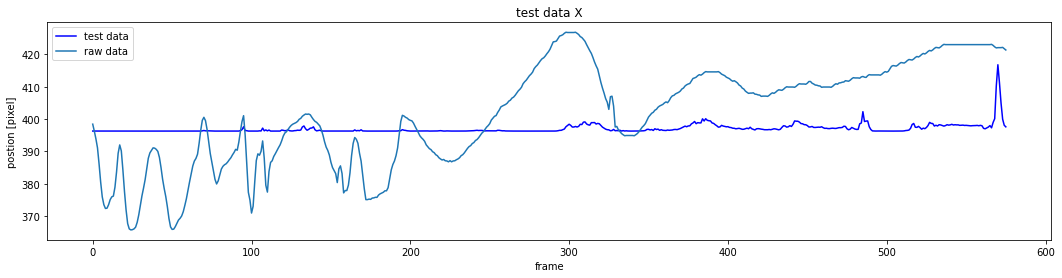

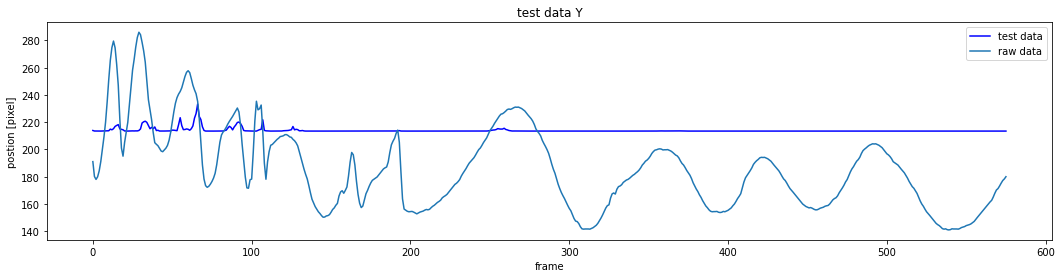

In [ ]:
#plot the 

#load the data:
xhat = yhat_test[:,0]
yhat = yhat_test[:,1]
data = [xhat, yhat]
group = ["X", "Y"]
for i in range(2):
  plt.subplots(figsize = (18,4))
  plt.plot(data[i],label = "test data", color = "blue")
  plt.plot(test_evaluation[:,i],label = "raw data")#, ls = "-.")
  plt.xlabel("frame")
  plt.ylabel("postion [pixel]")
  plt.title("test data {}".format(group[i]))
  plt.legend()
  plt.show()


#Prediction Part

In [ ]:
##import data and processing

#dataset for future prediction :
dataset = pd.read_csv(filepath_or_buffer = "/content/gdrive/My Drive/YAMAKAWA_LAB/marker_tracking_202207/30_0722/30fps/2_vel_files.csv")
value_eva = dataset.values
value_pred = dataset.values[:look_back,:]

#convert type of data into float
value_eva.astype("float32")
value_pred.astype("float32")

#normalized data
scaler = MinMaxScaler(feature_range = (-1,1))
scaled_eva = scaler.fit_transform(value_eva)
scaled_pred = scaler.fit_transform(value_pred)

#data as supervised learning
#reframed_pred = series_to_supervised(scaled_pred, look_back, 1)

#check the data
print(scaled_pred.shape)
#print(reframed_pred.shape)

(10, 4)


In [ ]:
# prediction part

init_data = scaled_pred
future_result = scaled_pred[:look_back, :]

# predicting future

for step in range(len(scaled_eva)):

  test_data = np.reshape(init_data, (1, look_back, dim))
  batch_predict = model.predict(test_data)
  init_data = np.delete(init_data, 0, axis =0) ## np.delete(data, deleted index, axis = (if colum : 1, if row : 0))
  init_data = np.append(init_data, batch_predict,axis = 0)
  future_result = np.append(future_result,batch_predict,axis = 0)
  #print(future_result)

y_pred = scaler.inverse_transform(future_result)
print(y_pred)
#y_eva = scaler.inverese_transform(scaled_eva)


[[437.         318.          51.         -17.        ]
 [463.         309.          26.          -9.        ]
 [441.         324.         -22.          15.        ]
 [394.         347.         -47.          23.        ]
 [349.         359.         -45.          12.        ]
 [328.         360.         -21.           1.        ]
 [334.         354.           6.          -6.        ]
 [360.         343.          26.         -11.        ]
 [397.         333.          37.         -10.        ]
 [417.         331.          20.          -2.        ]
 [395.54216928 352.09734061   2.27935803   9.07164681]
 [433.68415418 334.50085846  20.77564439   4.02197692]
 [403.06873183 351.81608427  11.88726266   3.14055352]
 [407.99672059 335.56936978  39.87186271   3.00064458]
 [395.52232788 349.62728772  21.78175679   3.05466105]
 [396.60247063 343.46083193  32.97829664   3.00103624]
 [396.66792479 335.84312666  47.46762943   3.04229836]
 [395.50352094 352.30799979  16.77067831   3.00304829]
 [410.9717

## Evaluate of Prediction

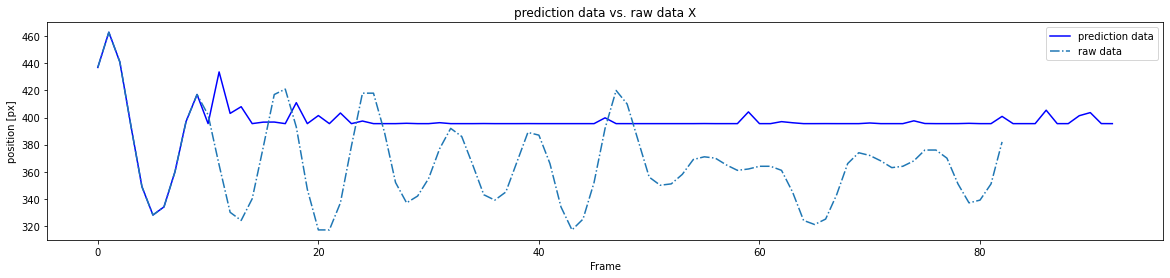

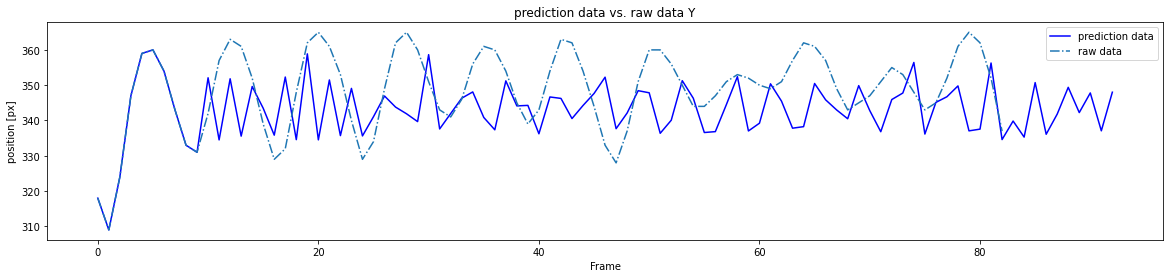

In [ ]:
## plot data :: 

group = ["X","Y"]

#for i in range(len(y_pred[i]))
for i in range(2):
  plt.subplots(figsize = (20,4))
  plt.plot(y_pred[:,i], label = "prediction data",color = "blue")
  plt.plot(value_eva[:,i], label = "raw data", linestyle = "-.")
  plt.xlabel("Frame")
  plt.ylabel("position [px]")
  plt.title("prediction data vs. raw data {}".format(group[i]))
  plt.legend()
  plt.show()


##Evaluate Error

0.0
[0.0, 10.558818885858125, 46.5893402008745, 43.79129872476793, 49.57670889129854, 28.579285424601153, 12.720078622566886, 13.247867371249416, 17.50411047327989, 36.213397843183444]


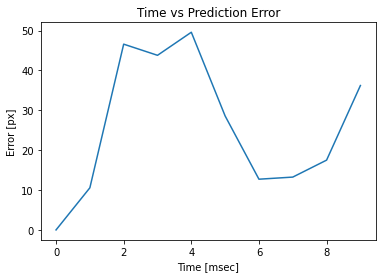

In [ ]:
## ::Plot accuracy of prediction data:

error=[]
time=[]

x_predict = y_pred[:, 0]
y_predict = y_pred[:,1]

def RMSE(dat1,dat2):
  sum=0
  for i in range(len(dat1)):
    sum+=(dat1[i]-dat2[i])**2
  sum=(sum/len(dat1))**(1/2)
  return sum

for i in range(0,10):
  rmse=RMSE(y_pred[i+look_back-1],value_eva[i+look_back-1]) 
  error.append(rmse)
print(error[0])
print(error)
plt.plot(error)
plt.title("Time vs Prediction Error")
plt.xlabel("Time [msec]")
plt.ylabel("Error [px]")
plt.show()